In [127]:
import os
import cv2
import math
import random
from PIL import Image
import numpy as np
import pandas as pd
from tqdm import tqdm

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.backends.cudnn as cudnn

from torch.utils.data.sampler import SequentialSampler, RandomSampler
from sklearn.model_selection import StratifiedKFold

from efficientnet_b6 import *

from albumentations import (
    HorizontalFlip, VerticalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine, RandomResizedCrop,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose, Normalize, Cutout, CoarseDropout, ShiftScaleRotate, CenterCrop, Resize
)
from albumentations.pytorch import ToTensorV2

data_path = os.path.abspath(os.path.join(os.path.curdir, 'input/cassava-leaf-disease-classification'))
train_path = os.path.join(data_path, 'train_images')
label_path = os.path.join(data_path, 'train.csv')
test_path = os.path.join(data_path, 'test_images')
csv_path = os.path.join(data_path, 'sample_submission.csv')
cwd = os.path.abspath('.')

cfg = {
    'fold_num': 5,
    'seed': 899,
    'model_arch': 'efficientnet-b4',
    'img_size': 384,
    'epochs': 3,
    'train_batch_size': 4,
    'val_batch_size': 8,
    'T_0': 10,
    'lr': 1e-4,
    'min_lr': 1e-6,
    'weight_decay': 1e-6,
    'num_workers': 4,
    'device': 'cuda:0'
}

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

def get_img(img_path):
    img_bgr = cv2.imread(img_path)
    return img_bgr[..., ::-1]

def get_train_transforms():
    return Compose([
            RandomResizedCrop(cfg['img_size'], cfg['img_size']),
            Transpose(p=0.5),
            HorizontalFlip(p=0.5),
            VerticalFlip(p=0.5),
            ShiftScaleRotate(p=0.5),
            HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5),
            RandomBrightnessContrast(brightness_limit=(-0.1,0.1), contrast_limit=(-0.1, 0.1), p=0.5),
            Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0, p=1.0),
            CoarseDropout(p=0.5),
            Cutout(p=0.5),
            ToTensorV2(p=1.0)
        ], p=1.0)


device = cfg['device']
best_acc = .0
best_loss = 0.39
label_df = pd.read_csv(label_path)
cudnn.benchmark = True

import os
import cv2
import tqdm
import random
from PIL import Image
import numpy as np
import pandas as pd

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.backends.cudnn as cudnn

from albumentations import (
    HorizontalFlip, VerticalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine, RandomResizedCrop,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose, Normalize, Cutout, CoarseDropout, ShiftScaleRotate, CenterCrop, Resize
)
from albumentations.pytorch import ToTensorV2

data_path = os.path.abspath(os.path.join(os.path.curdir, 'input/cassava-leaf-disease-classification'))
train_path = os.path.join(data_path, 'train_images')
label_path = os.path.join(data_path, 'train.csv')
test_path = os.path.join(data_path, 'test_images')
csv_path = os.path.join(data_path, 'submission.csv')
cwd = os.path.abspath('.')
cudnn.benchmark = True

def get_img(img_path):
    img_bgr = cv2.imread(img_path)
    return img_bgr[..., ::-1]

def get_valid_transforms():
    return Compose([
            CenterCrop(cfg['img_size'], cfg['img_size'], p=1.),
            Resize(cfg['img_size'], cfg['img_size']),
            Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0, p=1.0),
            ToTensorV2(p=1.0),
        ], p=1.0)

class CassavaDataset(Dataset):
    def __init__(self, df, dPath=None, transforms=None, test=False):
        super(CassavaDataset, self).__init__()
        self.df = df.reset_index(drop=True)
        self.dPath = dPath
        self.transforms = transforms
        self.test = test

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, idx):
        img_name = self.df['image_id'].values[idx]
        img_path = os.path.join(self.dPath, img_name)
        img = get_img(img_path)
        # img = np.array(img)
        img = self.transforms(image=img)['image']
        label = self.df['label'].values[idx]
        return img, label

def prepare_dataloader(label_df, train_idx, val_idx):
    train_df = label_df.loc[train_idx, :].reset_index(drop=True)
    val_df = label_df.loc[val_idx, :].reset_index(drop=True)

    train_dataset = CassavaDataset(train_df, train_path, get_train_transforms())
    val_dataset = CassavaDataset(val_df, train_path, get_valid_transforms())
    train_loader = DataLoader(train_dataset, batch_size=cfg['train_batch_size'], shuffle=True, num_workers=cfg['num_workers'])
    val_loader = DataLoader(val_dataset, batch_size=cfg['val_batch_size'], shuffle=False, num_workers=cfg['num_workers'])

    return train_loader, val_loader

torch.cuda.empty_cache()
cfg = {
    'fold_num': 5,
    'seed': 899,
    'model_arch': 'efficientnet-b6',
    'img_size': 384,
    'epochs': 8,
    'train_batch_size': 4,
    'val_batch_size': 8,
    'T_0': 10,
    'lr': 1e-4,
    'min_lr': 1e-6,
    'weight_decay': 1e-6,
    'num_workers': 1,
    'device': 'cuda:0'
}

def submission(csv_path, test_loader, device, nets):
    result_dict = {}
    result_dict['image_id'] = []
    result_dict['label'] = []
    
    for i in range(len(nets)):
        nets[i].eval()
        nets[i].to(device)
    
    with torch.no_grad():
        cnt = 0
        for inputs, ids in test_loader:
            x = inputs.to(device)
            x = torch.stack([x,
                            transforms.RandomHorizontalFlip(p=1)(x),
                            transforms.RandomVerticalFlip(p=1)(x),
                            ], 1)
            x = x.view(-1, 3, cfg['img_size'], cfg['img_size'])
            # print(x.shape)
            preds = torch.zeros(inputs.shape[0], 5).to(device)
            for i in range(len(nets)):
                outputs = nets[i](x)
                outputs = outputs.view(inputs.shape[0], 3, -1).mean(1)
                preds += torch.softmax(outputs, dim=1)
                # print(preds/(i+1))
            preds /= len(nets)
            # print(preds)
            preds = preds.argmax(dim=1)
            for idx, pred in enumerate(preds):
                result_dict['image_id'].append(ids[idx].item())
                result_dict['label'].append(pred.item())
            cnt += 1
            if cnt >= 25:
                break
    result_df = pd.DataFrame(data=result_dict)
    # result_df = result_df.sort_values('image_id')
    submission_path = 'submission.csv'
    result_df.to_csv(submission_path, index=None)
    return result_df

def check_models():
    device = torch.device('cuda')
    check_df = pd.read_csv(label_path)
    check_set = CassavaDataset(check_df, train_path, get_valid_transforms(), True)
    check_loader = torch.utils.data.DataLoader(check_set, batch_size=16, shuffle=True, num_workers=8)

    nets = []
    nets_name = os.listdir('checkpoint/')
    # nets_name = ['leaf-b4-fold3-loss.pth']
    for idx, name in enumerate(nets_name):
        if idx < 10:
            # print(name)
            net = EfficientNet.from_name('efficientnet-b4').to(device)
            net._fc = nn.Linear(net._fc.in_features, 5)
            net = torch.nn.DataParallel(net)
            checkpoint = torch.load(os.path.join('checkpoint', name))
            net.load_state_dict(checkpoint['net'])
            nets.append(net)

    df = submission(csv_path, check_loader, device, nets)
    return df

df = check_models()
sum(df.image_id.values == df.label.values) / 400

0.8775

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


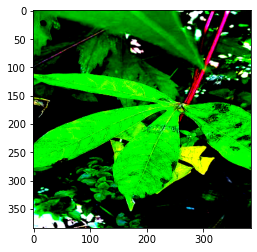

In [120]:
check_df = pd.read_csv(label_path)
check_set = CassavaDataset(check_df, train_path, get_valid_transforms(), True)
check_loader = torch.utils.data.DataLoader(check_set, batch_size=16, shuffle=True, num_workers=8)
xc, _ = next(iter(check_loader))
x = xc.data.cpu().numpy()
import matplotlib.pyplot as plt
plt.imshow(x[0].transpose(1,2,0))

In [121]:
xc.shape

torch.Size([16, 3, 384, 384])

In [122]:
xc = xc.to('cuda')
xc = torch.stack([xc,
                transforms.RandomHorizontalFlip(p=1)(xc),
                transforms.RandomVerticalFlip(p=1)(xc),
                ], 1)
xc = xc.view(-1, 3, cfg['img_size'], cfg['img_size'])
xc.shape

torch.Size([48, 3, 384, 384])

In [95]:
t = HorizontalFlip(p=0.9)
t(image=sample_img)

ValueError: step must be greater than zero

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


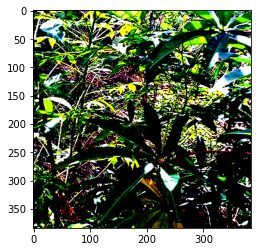

In [90]:
sample_img = x[1]
sample_img.shape
plt.imshow(sample_img)

In [85]:
sample_img

tensor([[[-0.3541,  0.2402, -0.4624],
         [-0.2513,  0.3452, -0.3578],
         [-0.0801,  0.4678, -0.1835],
         ...,
         [ 0.5364,  0.4153, -0.0441],
         [ 0.1597,  0.0476, -0.4101],
         [-0.1143, -0.2325, -0.6890]],

        [[-0.1314,  0.4153, -0.2010],
         [-0.0801,  0.4678, -0.1487],
         [-0.0116,  0.5378, -0.0790],
         ...,
         [ 0.2967,  0.1702, -0.3230],
         [-0.1143, -0.2150, -0.7238],
         [ 0.3138,  0.2402, -0.2707]],

        [[-0.5424, -0.0224, -0.6018],
         [-0.5596, -0.0399, -0.6193],
         [-0.5767, -0.0924, -0.6193],
         ...,
         [ 0.0569, -0.0749, -0.5670],
         [ 0.0741, -0.0224, -0.5670],
         [ 0.6563,  0.6078,  0.0431]],

        ...,

        [[-0.3883,  0.3277, -0.5147],
         [-0.3883,  0.3627, -0.4973],
         [-0.4911,  0.2052, -0.5670],
         ...,
         [-1.3644, -1.4580, -1.2990],
         [-1.3130, -1.4055, -1.2119],
         [-1.2617, -1.2304, -1.1596]],

        [[

In [81]:
x[0].shape

torch.Size([384, 384, 3])

TypeError: transpose() received an invalid combination of arguments - got (int, int, int), but expected one of:
 * (name dim0, name dim1)
 * (int dim0, int dim1)


In [74]:
x = torch.stack([x,
                 
                 transforms.RandomVerticalFlip(p=1)(x),
                ], 0)
x = x.view(-1, 3, cfg['img_size'], cfg['img_size'])
x.shape

ValueError: step must be greater than zero

In [62]:
x = x.data.cpu().numpy()
x.shape

(48, 3, 384, 384)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


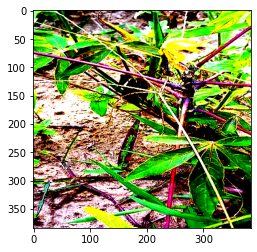

In [63]:
import matplotlib.pyplot as plt
sample_img = x[0].transpose(1,2,0)
sample_img.shape
plt.imshow(sample_img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


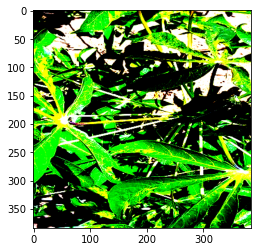

In [65]:
sample_img = x[2].transpose(1,2,0)
sample_img.shape
plt.imshow(sample_img)